<a href="https://colab.research.google.com/github/rahul2003yadav/inventory-demand-forecasting/blob/main/Inventory_demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
df = pd.read_csv('data.csv')


In [ ]:
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   record_ID        150150 non-null  int64  
 1   week             150150 non-null  object 
 2   store_id         150150 non-null  int64  
 3   sku_id           150150 non-null  int64  
 4   total_price      150149 non-null  float64
 5   base_price       150150 non-null  float64
 6   is_featured_sku  150150 non-null  int64  
 7   is_display_sku   150150 non-null  int64  
 8   units_sold       150150 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 10.3+ MB
None


In [ ]:
# Set datetime feature columns if any
date_features = ['date_field_1', 'date_field_2']  # replace or leave empty if none

In [ ]:
categorical_fields = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_fields


['week']

In [ ]:
numerical_fields = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_fields


['record_ID',
 'store_id',
 'sku_id',
 'total_price',
 'base_price',
 'is_featured_sku',
 'is_display_sku',
 'units_sold']

In [ ]:
missing_values = df.isnull().sum()
missing_values


,0
record_ID,0
week,0
store_id,0
sku_id,0
total_price,1
base_price,0
is_featured_sku,0
is_display_sku,0
units_sold,0


In [ ]:
from sklearn.impute import SimpleImputer

# Select only numerical columns for imputation
numerical_data = df.select_dtypes(include=[np.number])

# Create imputer object with mean strategy
imputer = SimpleImputer(strategy='mean')

# Fit and transform numerical data to impute missing values
df[numerical_data.columns] = imputer.fit_transform(numerical_data)


In [ ]:
df


,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1.0,17/01/11,8091.0,216418.0,99.0375,111.8625,0.0,0.0,20.0
1,2.0,17/01/11,8091.0,216419.0,99.0375,99.0375,0.0,0.0,28.0
2,3.0,17/01/11,8091.0,216425.0,133.9500,133.9500,0.0,0.0,19.0
3,4.0,17/01/11,8091.0,216233.0,133.9500,133.9500,0.0,0.0,44.0
4,5.0,17/01/11,8091.0,217390.0,141.0750,141.0750,0.0,0.0,52.0
...,...,...,...,...,...,...,...,...,...
150145,212638.0,09/07/13,9984.0,223245.0,235.8375,235.8375,0.0,0.0,38.0
150146,212639.0,09/07/13,9984.0,223153.0,235.8375,235.8375,0.0,0.0,30.0
150147,212642.0,09/07/13,9984.0,245338.0,357.6750,483.7875,1.0,1.0,31.0
150148,212643.0,09/07/13,9984.0,547934.0,141.7875,191.6625,0.0,1.0,12.0


Create a new column 'key' for unique identification. This is done in order to handle the duplicate data in 'week' column.



In [ ]:
df['key'] = df['week'].astype(str) + '_' + df['store_id'].astype(str)


Removing columns that are not helpful for time series predictions.

> Add blockquote





In [ ]:
df_processed = df.drop(['record_ID', 'week', 'store_id', 'sku_id', 'total_price', 'base_price', 'is_featured_sku', 'is_display_sku'], axis=1)


Summing units_sold group by key.



In [ ]:
df_grouped = df.groupby('key').sum()


In [ ]:
df

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,key
0,1.0,17/01/11,8091.0,216418.0,99.0375,111.8625,0.0,0.0,20.0,17/01/11_8091.0
1,2.0,17/01/11,8091.0,216419.0,99.0375,99.0375,0.0,0.0,28.0,17/01/11_8091.0
2,3.0,17/01/11,8091.0,216425.0,133.9500,133.9500,0.0,0.0,19.0,17/01/11_8091.0
3,4.0,17/01/11,8091.0,216233.0,133.9500,133.9500,0.0,0.0,44.0,17/01/11_8091.0
4,5.0,17/01/11,8091.0,217390.0,141.0750,141.0750,0.0,0.0,52.0,17/01/11_8091.0
...,...,...,...,...,...,...,...,...,...,...
150145,212638.0,09/07/13,9984.0,223245.0,235.8375,235.8375,0.0,0.0,38.0,09/07/13_9984.0
150146,212639.0,09/07/13,9984.0,223153.0,235.8375,235.8375,0.0,0.0,30.0,09/07/13_9984.0
150147,212642.0,09/07/13,9984.0,245338.0,357.6750,483.7875,1.0,1.0,31.0,09/07/13_9984.0
150148,212643.0,09/07/13,9984.0,547934.0,141.7875,191.6625,0.0,1.0,12.0,09/07/13_9984.0


<Axes: >

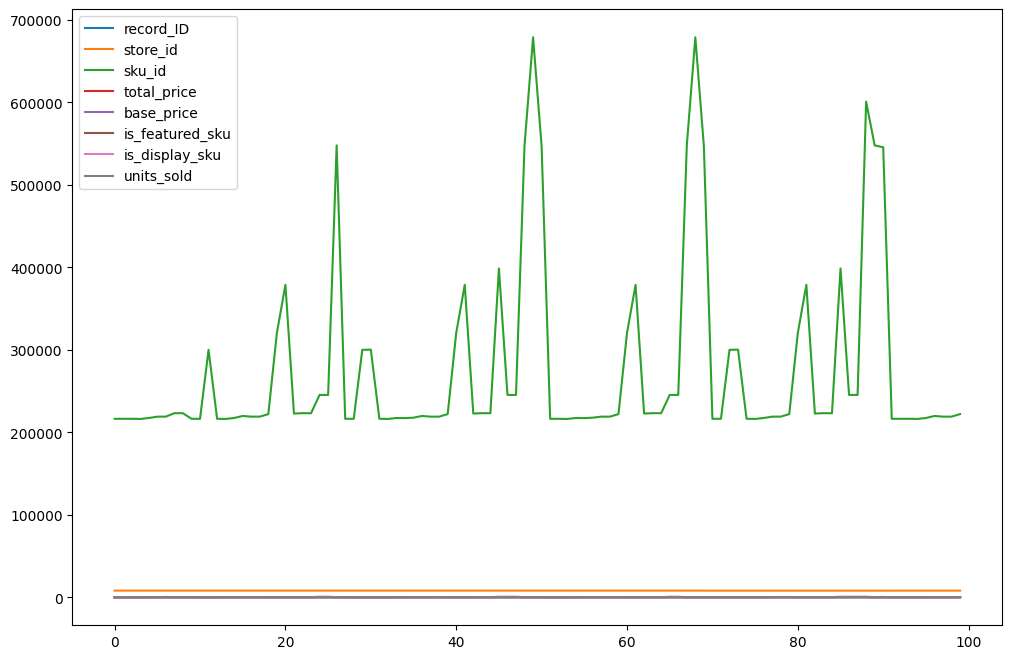

In [ ]:
df.iloc[:100].plot(figsize=(12,8))


Converting supervised dataset
units_sold becomes target variable

day_1, day_2, day_3, day_4 becomes input

We will train our model to predict sales based on previous 4 days.

In [ ]:
df['day_1'] = df['units_sold'].shift(-1)
df['day_2'] = df['units_sold'].shift(-2)
df['day_3'] = df['units_sold'].shift(-3)
df['day_4'] = df['units_sold'].shift(-4)


In [ ]:
df

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,key,day_1,day_2,day_3,day_4
0,1.0,17/01/11,8091.0,216418.0,99.0375,111.8625,0.0,0.0,20.0,17/01/11_8091.0,28.0,19.0,44.0,52.0
1,2.0,17/01/11,8091.0,216419.0,99.0375,99.0375,0.0,0.0,28.0,17/01/11_8091.0,19.0,44.0,52.0,18.0
2,3.0,17/01/11,8091.0,216425.0,133.9500,133.9500,0.0,0.0,19.0,17/01/11_8091.0,44.0,52.0,18.0,47.0
3,4.0,17/01/11,8091.0,216233.0,133.9500,133.9500,0.0,0.0,44.0,17/01/11_8091.0,52.0,18.0,47.0,50.0
4,5.0,17/01/11,8091.0,217390.0,141.0750,141.0750,0.0,0.0,52.0,17/01/11_8091.0,18.0,47.0,50.0,82.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150145,212638.0,09/07/13,9984.0,223245.0,235.8375,235.8375,0.0,0.0,38.0,09/07/13_9984.0,30.0,31.0,12.0,15.0
150146,212639.0,09/07/13,9984.0,223153.0,235.8375,235.8375,0.0,0.0,30.0,09/07/13_9984.0,31.0,12.0,15.0,NaN
150147,212642.0,09/07/13,9984.0,245338.0,357.6750,483.7875,1.0,1.0,31.0,09/07/13_9984.0,12.0,15.0,NaN,NaN
150148,212643.0,09/07/13,9984.0,547934.0,141.7875,191.6625,0.0,1.0,12.0,09/07/13_9984.0,15.0,NaN,NaN,NaN


Remove NA data



In [ ]:
df = df.dropna()


<Axes: >

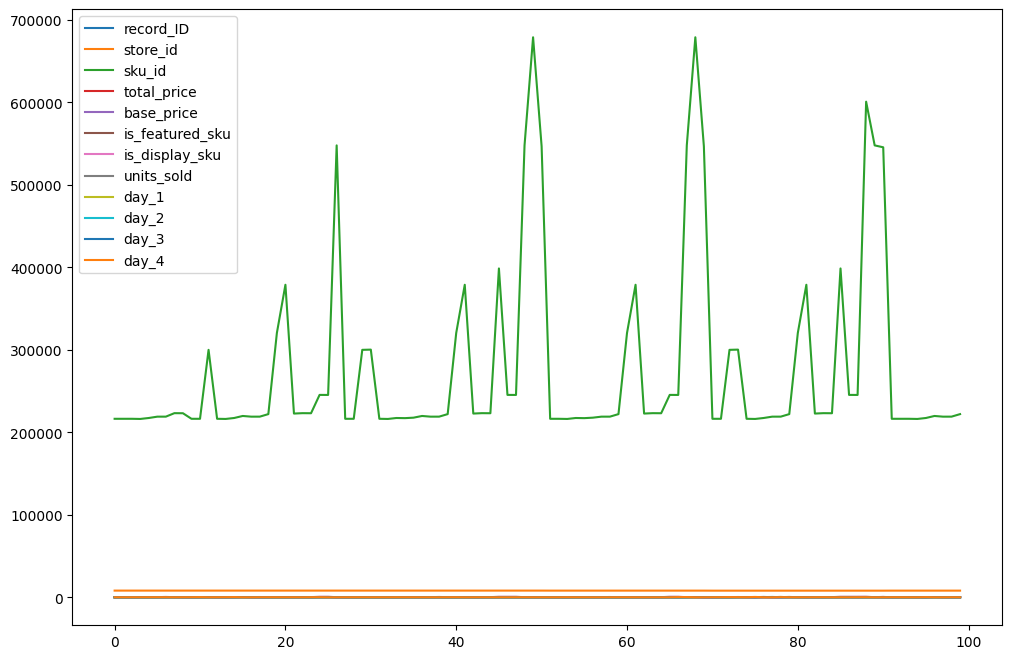

In [ ]:
df.iloc[:100].plot(figsize=(12,8))


Train-Test Split


In [ ]:
x1, x2, x3, x4, y = df['day_1'], df['day_2'], df['day_3'], df['day_4'], df['units_sold']
x1, x2, x3, x4, y = map(lambda arr: arr.values.reshape(-1, 1), [x1, x2, x3, x4, y])

split_percentage = 15
test_split = int(len(df) * (split_percentage / 100))
x = np.concatenate((x1, x2, x3, x4), axis=1)

X_train, X_test = x[:-test_split], x[-test_split:]
y_train, y_test = y[:-test_split], y[-test_split:]


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(127625, 4)
(22521, 4)
(127625, 1)
(22521, 1)


Random Forest Regression


In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
print("R Sq. Score for Random Forest Regression :", rf_regressor.score(X_test, y_test))


R Sq. Score for Random Forest Regression : -0.046737280823061056


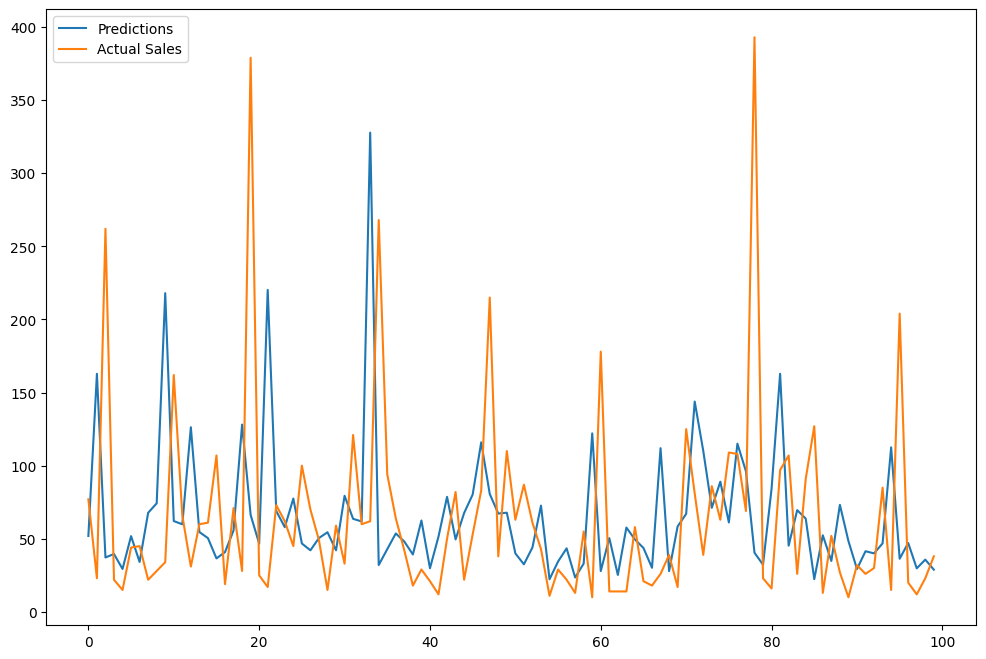

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(y_pred[-100:], label='Predictions')
plt.plot(y_test[-100:], label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

[link text](https://)Hyperparameter Tuning for Random Forest


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 250, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt', 'log2', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 120, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [50, 72, 94, 116, 138, 161, 183, 205, 227, 250], 'max_features': ['sqrt', 'log2', None], 'max_depth': [1, 7, 13, 19, 26, 32, 38, 44, 51, 57, 63, 69, 76, 82, 88, 94, 101, 107, 113, 120, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=0, n_jobs = -1)

In [ ]:
rf_random.fit(X_train, y_train.ravel())


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 7, 13, 19, 26, 32, 38,
                                                      44, 51, 57, 63, 69, 76,
                                                      82, 88, 94, 101, 107, 113,
                                                      120, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 72, 94, 116, 138,
                                                         161, 183, 205, 227,
                                                         250]},
                   random_state=0, verbose=2)

In [ ]:
rf_random.best_params_


{'n_estimators': 116,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 101,
 'bootstrap': True}

In [ ]:
best_random = rf_random.best_estimator_


In [ ]:
y_pred = best_random.predict(X_test)


In [ ]:
print("R Sq. Score for Random Forest Regression :", best_random.score(X_test, y_test))
print("Adj. R Sq. Score for Random Forest Regression :", 1 - (1 - best_random.score(X_test, y_test) ) * ( len(y_test) - 1 ) / ( len(y_test) - X_test.shape[1] - 1 ))

R Sq. Score for Random Forest Regression : 0.04287134219431521
Adj. R Sq. Score for Random Forest Regression : 0.04270130690246843


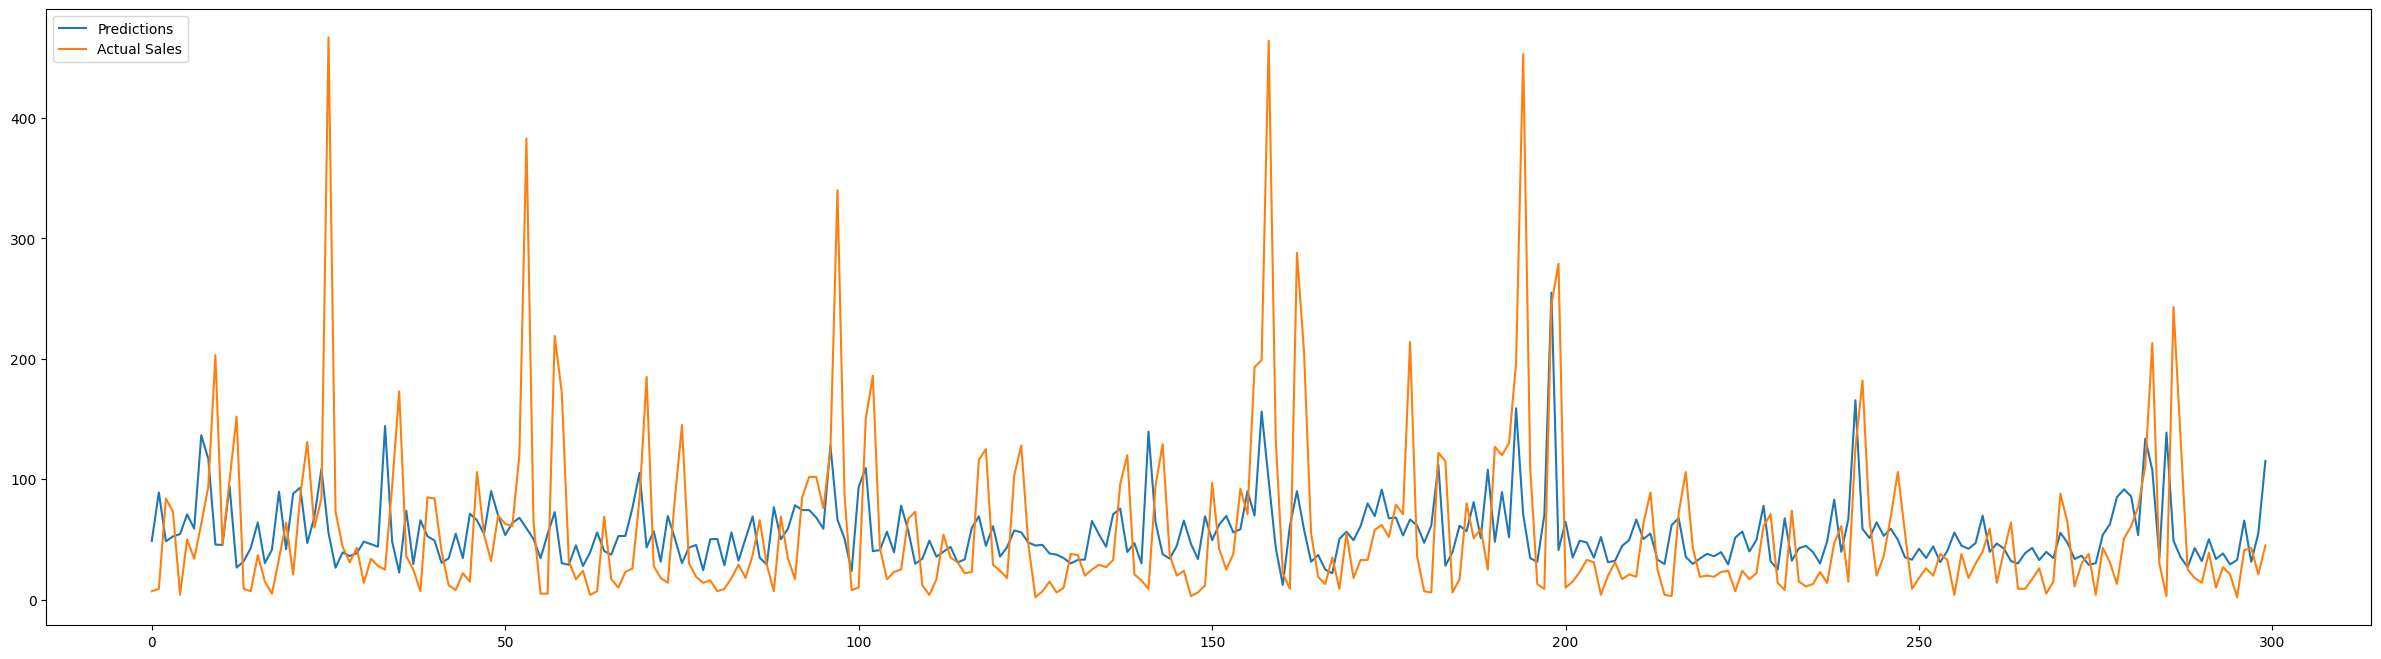

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,8)
plt.plot(y_pred[500:800], label='Predictions')
plt.plot(y_test[500:800], label='Actual Sales')
plt.legend(loc="upper left")
plt.savefig('final.png')
plt.show()